In [ ]:
import os
import random
import cv2
import numpy as np
import pandas as pd

def load_utkface_dataset(image_dir="./data/images"):
    images, labels = [], []

    # Limit loading for speed (e.g., 50 random files)
    all_files = os.listdir(image_dir)
    random.shuffle(all_files)
    max_images = 24108

    for file_name in all_files[:max_images]:
        name = os.path.splitext(file_name)[0].replace(".chip", "")
        parts = name.split("_")

        # Expecting 4 parts: [age, gender, race, date]
        if len(parts) != 4 or any(p == "" for p in parts):
            continue

        try:
            age, gender, race = int(parts[0]), int(parts[1]), int(parts[2])
            date = parts[3]
        except ValueError:
            continue

        # Validate values
        if not (0 <= age <= 116 and gender in (0, 1) and 0 <= race <= 4 and len(date) == 17):
            continue

        img_path = os.path.join(image_dir, file_name)
        img = cv2.imread(img_path)

        if img is None:
            print(f"[Warning] Failed to read: {file_name}")
            continue

        # Convert from BGR (OpenCV) → RGB (matplotlib expects this)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Check image properties
        if img.ndim != 3 or img.shape[2] != 3:
            print(f"[Warning] Unexpected format for: {file_name}, shape={img.shape}")
            continue

        images.append(img)
        labels.append({
            "age": age,
            "gender": gender,
            "race": race,
            "datetime": date
        })

    print(f"Loaded {len(images)} valid images out of {len(all_files)} files.")

    # 1a. Dataset Summary Statistics
    df = pd.DataFrame(labels)

    print("\n=== Dataset Summary ===")
    print(f"Total images: {len(df)}")
    print(f"Age range: {df['age'].min()} - {df['age'].max()} (mean: {df['age'].mean():.1f})")
    print(f"Gender distribution:\n{df['gender'].value_counts()}")
    print(f"Race distribution:\n{df['race'].value_counts()}")
    print(f"Average image size (HxW): {np.mean([img.shape[:2] for img in images], axis=0).astype(int)}")

    return images, labels, df

In [ ]:
# --- Step 1: Load data ---
images, labels, df = load_utkface_dataset("./data/images")

C:\Users\kayam\AppData\Local\Programs\Python\Python312\python.exe "C:\Users\kayam\Downloads\CVNLP (5.Semester)\Computer Vision Project\main.py"
2025-10-28 03:44:24.934878: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable 'TF_ENABLE_ONEDNN_OPTS=0'.
Loaded 24099 valid images out of 24108 files.

=== Dataset Summary ===
Total images: 24099
Age range: 1 - 116 (mean: 33.0)
Gender distribution:
gender
0    12578
1    11521
Name: count, dtype: int64
Race distribution:
race
0    10220
1     4556
3     4027
2     3585
4     1711
Name: count, dtype: int64
Average image size (HxW): [662 637]

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.container import BarContainer
from collections import Counter

def plot_random_samples(images, labels, gender_map, race_map):
    # --- Random sample visualization ---
    plt.figure(figsize=(10, 6))
    for i, idx in enumerate(random.sample(range(len(images)), min(9, len(images)))):
        img = images[idx]
        label = labels[idx]
        plt.subplot(3, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        gender_value = label.get("gender")
        race_value = label.get("race")
        plt.title(
            f'Age: {label["age"]}\n'
            f'Gender: {gender_map.get(gender_value, gender_value)} '
            f'Race: {race_map.get(race_value, race_value)}',
            fontsize=10,
            color="#4A4A4A"
        )
    plt.suptitle("Random Sample of UTKFace Images", fontsize=14, color="#333333", weight="bold")
    plt.tight_layout()
    plt.show()

In [ ]:
# --- Step 2: Visualize ---
plot_random_samples(images, labels, gender_map={0:"Male",1:"Female"},
                    race_map={0:"White",1:"Black",2:"Asian",3:"Indian",4:"Other"})

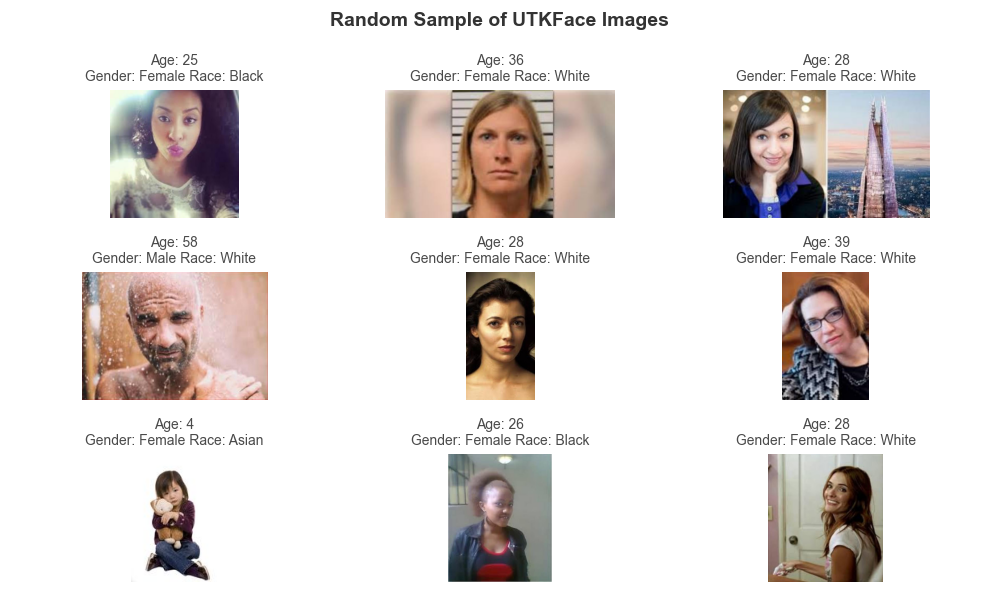

In [ ]:
def plot_distribution_charts(df):
    # Set theme and gentle palette
    sns.set_theme(style="whitegrid")
    rosa_palette = ["#F9C5D5", "#F7A1C4", "#F48FB1", "#F06292", "#EC407A"]

    # --- Age distribution histogram ---
    plt.figure(figsize=(8, 5))
    sns.histplot(df["age"], color="#F48FB1", kde=True)
    plt.title('Age Distribution', fontsize=14, color="#333333", weight="bold")
    plt.xlabel('Age', fontsize=12)
    plt.ylabel('Frequency', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # --- Gender balance ---
    plt.figure(figsize=(6, 5))
    ax = sns.countplot(data=df, x="gender", hue="gender",
                       palette=["#F9C5D5", "#F48FB1"], legend=False)
    for container in ax.containers:
        if isinstance(container, BarContainer):
            ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
    plt.title("Gender Balance", fontsize=14, color="#333333", weight="bold")
    plt.xlabel("Gender", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # --- Race balance ---
    plt.figure(figsize=(7, 5))
    ax = sns.countplot(data=df, x="race", hue="race", palette=rosa_palette, legend=False)
    for container in ax.containers:
        if isinstance(container, BarContainer):
            ax.bar_label(container, fmt='%d', label_type='edge', fontsize=10)
    plt.title("Race Balance", fontsize=14, color="#333333", weight="bold")
    plt.xlabel("Race", fontsize=12)
    plt.ylabel("Count", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # --- Age distribution by gender ---
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df, x="gender", y="age", hue="gender",
                palette=["#F9C5D5", "#F48FB1"], legend=False, showfliers=True)
    plt.title("Age Distribution by Gender", fontsize=14, color="#333333", weight="bold")
    plt.xlabel("Gender", fontsize=12)
    plt.ylabel("Age", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

    # --- Age distribution by race ---
    plt.figure(figsize=(9, 5))
    sns.boxplot(data=df, x="race", y="age", hue="race",
                palette=rosa_palette, legend=False, showfliers=True)
    plt.title("Age Distribution by Race", fontsize=14, color="#333333", weight="bold")
    plt.xlabel("Race", fontsize=12)
    plt.ylabel("Age", fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.show()

In [ ]:
plot_distribution_charts(df)

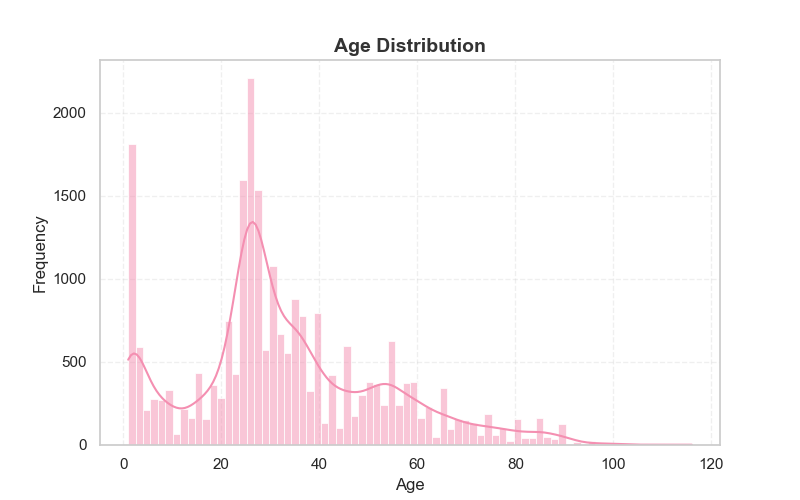
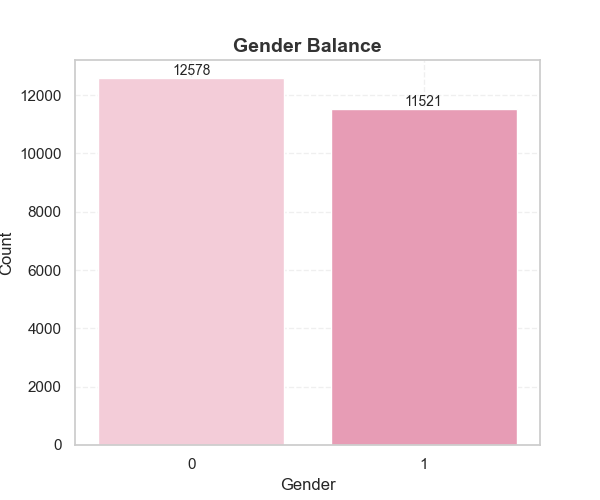
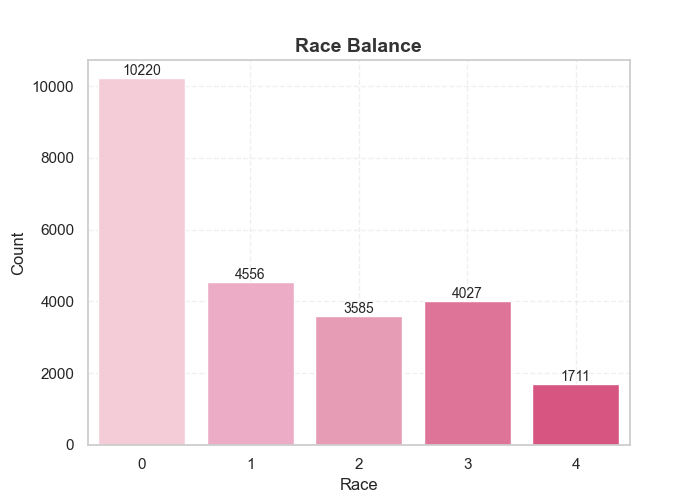
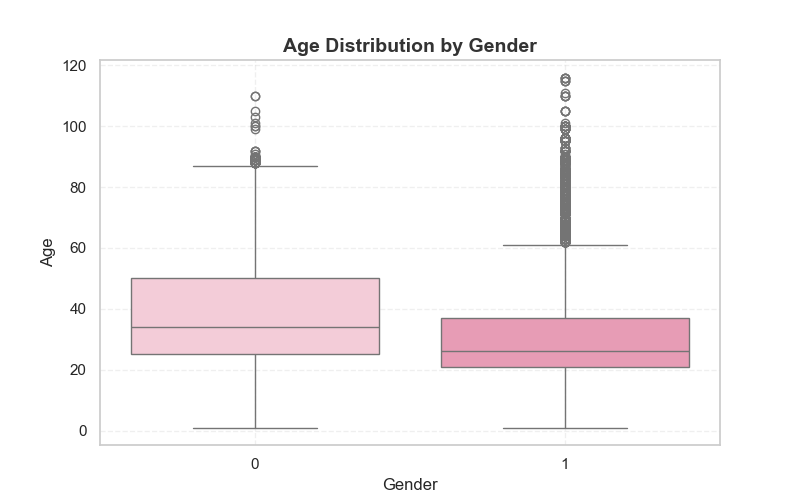
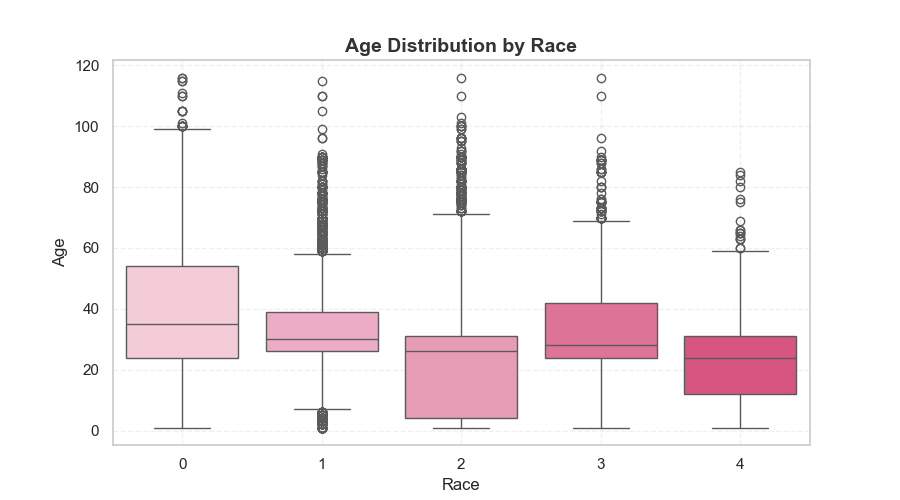

In [ ]:
import gc
import pickle
from sklearn.model_selection import train_test_split

def preprocess_images_to_memmap(images, labels, target_size=(160, 160), save_X_path=None, save_y_path=None):
    """
    Resize images and save to memmap files on disk.
    - images: list of numpy arrays (RGB uint8)
    - labels: list of dicts, each must contain 'age' key
    - save_X_path, save_y_path: exact paths for memmap files (required)
    """
    if save_X_path is None or save_y_path is None:
        raise ValueError("Must provide save_X_path and save_y_path")

    os.makedirs(os.path.dirname(save_X_path), exist_ok=True)

    n = len(images)
    w, h = target_size
    print(f"Writing memmap files ({w}x{h}) ... (n={n})")

    if os.path.exists(save_X_path) and os.path.exists(save_y_path):
        print(f"Memmap files already exist:\n  {save_X_path}\n  {save_y_path}")
        return save_X_path, save_y_path

    # Create writable memmaps
    X_mm = np.memmap(save_X_path, dtype=np.float16, mode="w+", shape=(n, h, w, 3))
    y_mm = np.memmap(save_y_path, dtype=np.float32, mode="w+", shape=(n,))

    for i, img in enumerate(images):
        if img is None:
            raise ValueError(f"Image at index {i} is None")
        resized = cv2.resize(img, target_size, interpolation=cv2.INTER_AREA)
        X_mm[i] = (resized.astype(np.float32) / 255.0).astype(np.float16)
        y_mm[i] = float(labels[i]["age"])
        if (i + 1) % 1000 == 0 or (i + 1) == n:
            print(f"  Processed {i + 1}/{n} images", end="\r")

    del X_mm, y_mm
    gc.collect()
    print(f"\nMemmap creation finished for {w}x{h}.")

In [ ]:
# --- 3. Data Preprocessing (disk-based via memmap) ---
target_size = (192, 192)  # or (160, 160) or (224, 224)
memmap_dir = "./data/memmap"
size_tag = f"{target_size[0]}x{target_size[1]}"
X_path = os.path.join(memmap_dir, f"X_resized_{size_tag}.dat")
y_path = os.path.join(memmap_dir, f"y_resized_{size_tag}.dat")

# Create memmap only if it doesn’t exist yet
if not (os.path.exists(X_path) and os.path.exists(y_path)):
    preprocess_images_to_memmap(images, labels, target_size=target_size, save_X_path=X_path, save_y_path=y_path)
else:
    print("Memmap files already exist — skipping preprocessing.")

Memmap files already exist — skipping preprocessing.

In [ ]:
def load_and_split_from_memmap(X_path, y_path, n_samples, target_size=(160,160), normalize_01=True, random_seed=42,
                               age_bins=None, save_split_info=True,
                               split_info_path="./dataset_split/dataset_split_info.pkl"):
    """
    Load memmap files and perform stratified train/val/test splits.
    Returns the dictionary of objects (same interface you used before),
    but X_train/X_val/X_test are memmap slices (views) — no full-copy in RAM.
    """
    # Cleanup
    for name in ["X", "X_tmp", "X_train", "X_val", "X_test", "dbg_X", "dbg_y", "dbg_w"]:
        if name in globals():
            del globals()[name]
    gc.collect()

    rng = np.random.default_rng(random_seed)
    NORMALIZE_01 = normalize_01
    AGE_BINS = age_bins or [0, 5, 12, 18, 30, 45, 60, 80, 200]

    # Map memmaps read-only (float16 normalized)
    X_all = np.memmap(X_path, dtype=np.float16, mode="r", shape=(n_samples, target_size[1], target_size[0], 3))
    y_all = np.memmap(y_path, dtype=np.float32, mode="r", shape=(n_samples,))

    # Extract ages as numpy array (this does not copy the whole memmap; small view)
    ages = np.array(y_all, dtype=np.float32) # ages fits in RAM (one scalar per image)

    # Stratified splits using age bins
    bins_idx = np.digitize(ages, AGE_BINS, right=False) - 1
    idx_all = np.arange(len(ages))

    idx_tmp, idx_test, ages_tmp, ages_test, bins_tmp, bins_test = train_test_split(
        idx_all, ages, bins_idx,
        test_size=0.15, random_state=random_seed, stratify=bins_idx
    )

    val_ratio_of_remaining = 0.15 / (1.0 - 0.15)
    idx_train, idx_val, ages_train, ages_val, bins_train, bins_val = train_test_split(
        idx_tmp, ages_tmp, bins_tmp,
        test_size=val_ratio_of_remaining, random_state=random_seed, stratify=bins_tmp
    )

    # IMPORTANT: slice the memmap (these are views, not full copies)
    X_train = X_all[idx_train]
    X_val   = X_all[idx_val]
    X_test  = X_all[idx_test]

    # numeric label arrays
    y_train = ages_train
    y_val   = ages_val
    y_test  = ages_test

    # Standardize ages (small arrays in RAM)
    age_mean = y_train.mean()
    age_std = y_train.std()

    y_train_std = (y_train - age_mean) / age_std
    y_val_std = (y_val - age_mean) / age_std
    y_test_std = (y_test - age_mean) / age_std

    print(f"Age mean: {age_mean:.2f}, std: {age_std:.2f}")

    # NOTE: X_train etc are still float16 normalized [0,1] if preprocessed that way.
    # If caller wants float32 normalized arrays, they should convert per-batch (not whole arrays).
    print("Train/Val/Test memmap slice shapes:", X_train.shape, X_val.shape, X_test.shape)
    print("Bin counts (train):", Counter(bins_train))
    print("Bin counts (val):  ", Counter(bins_val))
    print("Bin counts (test): ", Counter(bins_test))

    # Save split info
    if save_split_info:
        split_info = {
            "idx_train": idx_train,
            "idx_val": idx_val,
            "idx_test": idx_test,
            "age_mean": float(age_mean),
            "age_std": float(age_std),
            "y_all": ages,
            "AGE_BINS": AGE_BINS,
            "RANDOM_SEED": random_seed
        }
        os.makedirs(os.path.dirname(split_info_path), exist_ok=True)
        with open(split_info_path, "wb") as f:
            pickle.dump(split_info, f)
        print(f"Split info saved to: {split_info_path}")

    return {
        "rng": rng,
        "NORMALIZE_01": NORMALIZE_01,
        "AGE_BINS": AGE_BINS,
        "bins_train": bins_train,
        "bins_val": bins_val,
        "bins_test": bins_test,
        "X_train": X_train,
        "X_val": X_val,
        "X_test": X_test,
        "y_train": y_train,
        "y_val": y_val,
        "y_test": y_test,
        "age_mean": age_mean,
        "age_std": age_std,
        "y_train_std": y_train_std,
        "y_val_std": y_val_std,
        "y_test_std": y_test_std,
    }

In [ ]:
n_samples = len(images)

preproc = load_and_split_from_memmap(
    X_path=X_path,
    y_path=y_path,
    n_samples=n_samples,
    target_size=target_size,
    normalize_01=True
)

Age mean: 33.05, std: 20.17

Train/Val/Test memmap slice shapes: (16869, 192, 192, 3) (3615, 192, 192, 3) (3615, 192, 192, 3)

Bin counts (train): Counter({np.int64(3): 5408, np.int64(4): 4007, np.int64(5): 2363, np.int64(0): 1682, np.int64(6): 1434, np.int64(1): 807, np.int64(2): 679, np.int64(7): 489})

Bin counts (val):   Counter({np.int64(3): 1159, np.int64(4): 859, np.int64(5): 506, np.int64(0): 361, np.int64(6): 307, np.int64(1): 173, np.int64(2): 145, np.int64(7): 105})

Bin counts (test):  Counter({np.int64(3): 1159, np.int64(4): 859, np.int64(5): 506, np.int64(0): 361, np.int64(6): 307, np.int64(1): 173, np.int64(2): 145, np.int64(7): 105})

Split info saved to: ./dataset_split/dataset_split_info.pkl

In [ ]:
def plot_age_bin_distribution(bins_train, bins_val, bins_test, AGE_BINS, rosa_palette=None):
    """
    Visualize stratified splits by age bins for train, val, and test sets.

    Parameters
    ----------
    bins_train, bins_val, bins_test : array-like
        Arrays of bin indices corresponding to train, val, test splits.
    AGE_BINS : list[int]
        List of age bin edges.
    rosa_palette : list[str], optional
        Custom colors for the train/val/test bars. Defaults to pink-inspired palette.

    Returns
    -------
    bin_labels : list[str]
        Human-readable labels for each age bin.
    """

    # --- Default rosa-inspired palette ---
    if rosa_palette is None:
        rosa_palette = ["#F9C5D5", "#F48FB1", "#EC407A"]

    K = len(AGE_BINS) - 1

    # --- Create bin labels ---
    bin_labels = []
    for i in range(K):
        lo, hi = AGE_BINS[i], AGE_BINS[i + 1]
        if i < K - 1:
            bin_labels.append(f"{lo}–{hi-1}")
        else:
            bin_labels.append(f"{lo}+")

    # --- Helper function to count occurrences ---
    def counts_in_order(counter, K):
        return np.array([counter.get(i, 0) for i in range(K)], dtype=np.int32)

    train_counts = counts_in_order(Counter(bins_train), K)
    val_counts   = counts_in_order(Counter(bins_val), K)
    test_counts  = counts_in_order(Counter(bins_test), K)

    x = np.arange(K)
    w = 0.25

    # --- Raw counts plot ---
    plt.figure(figsize=(12, 5))
    sns.set_theme(style="whitegrid")

    plt.bar(x - w, train_counts, width=w, label="Train", color=rosa_palette[0])
    plt.bar(x, val_counts, width=w, label="Val", color=rosa_palette[1])
    plt.bar(x + w, test_counts, width=w, label="Test", color=rosa_palette[2])

    plt.xticks(x, bin_labels, rotation=0, fontsize=11, color="#333333")
    plt.xlabel("Age Bins", fontsize=12, color="#333333")
    plt.ylabel("Count", fontsize=12, color="#333333")
    plt.title("Age-bin Distribution: Train vs Val vs Test (Counts)",
              fontsize=14, color="#333333", weight="bold")
    plt.grid(True, linestyle='--', alpha=0.3)
    plt.legend(title="", fontsize=11, loc="upper right", frameon=False)
    plt.tight_layout()
    plt.show()

    # --- Normalized percentages plot ---
    train_pct = (train_counts / train_counts.sum()) * 100.0
    val_pct   = (val_counts / val_counts.sum()) * 100.0
    test_pct  = (test_counts / test_counts.sum()) * 100.0

    plt.figure(figsize=(12, 5))
    sns.set_theme(style="whitegrid")

    plt.bar(x - w, train_pct, width=w, label="Train", color=rosa_palette[0])
    plt.bar(x, val_pct, width=w, label="Val", color=rosa_palette[1])
    plt.bar(x + w, test_pct, width=w, label="Test", color=rosa_palette[2])

    plt.xticks(x, bin_labels, rotation=0, fontsize=11, color="#333333")
    plt.xlabel("Age Bins", fontsize=12, color="#333333")
    plt.ylabel("Share (%)", fontsize=12, color="#333333")
    plt.title("Age-bin Distribution: Train vs Val vs Test (Percent)",
              fontsize=14, color="#333333", weight="bold")

    plt.grid(True, linestyle='--', alpha=0.3)
    for i, (tp, vp, sp) in enumerate(zip(train_pct, val_pct, test_pct)):
        plt.text(i - w, tp + 0.5, f"{tp:.1f}%", ha='center', va='bottom', fontsize=9, color="#4A4A4A")
        plt.text(i, vp + 0.5, f"{vp:.1f}%", ha='center', va='bottom', fontsize=9, color="#4A4A4A")
        plt.text(i + w, sp + 0.5, f"{sp:.1f}%", ha='center', va='bottom', fontsize=9, color="#4A4A4A")

    plt.legend(title="", fontsize=11, loc="upper right", frameon=False)
    plt.tight_layout()
    plt.show()

In [ ]:
# Unpack all returned objects
rng = preproc["rng"]
NORMALIZE_01 = preproc["NORMALIZE_01"]
AGE_BINS = preproc["AGE_BINS"]

bins_train = preproc["bins_train"]
bins_val = preproc["bins_val"]
bins_test = preproc["bins_test"]

X_train = preproc["X_train"]
X_val = preproc["X_val"]
X_test = preproc["X_test"]

y_train = preproc["y_train"]
y_val = preproc["y_val"]
y_test = preproc["y_test"]

y_train_std = preproc["y_train_std"]
y_val_std = preproc["y_val_std"]
y_test_std = preproc["y_test_std"]

age_mean = preproc["age_mean"]
age_std = preproc["age_std"]

# --- Visualize stratified splits by age bins ---
plot_age_bin_distribution(bins_train=bins_train, bins_val=bins_val, bins_test=bins_test, AGE_BINS=AGE_BINS)

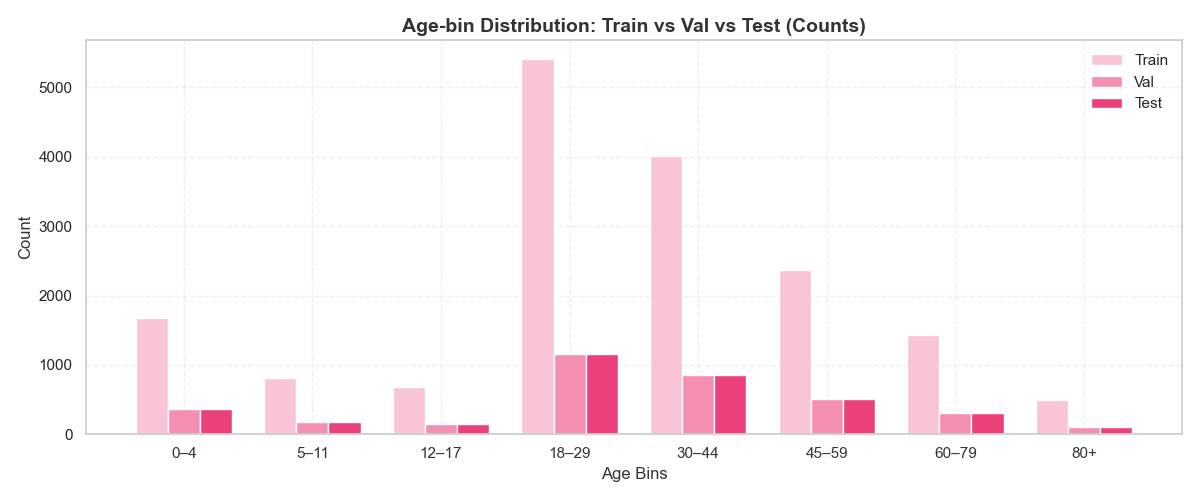
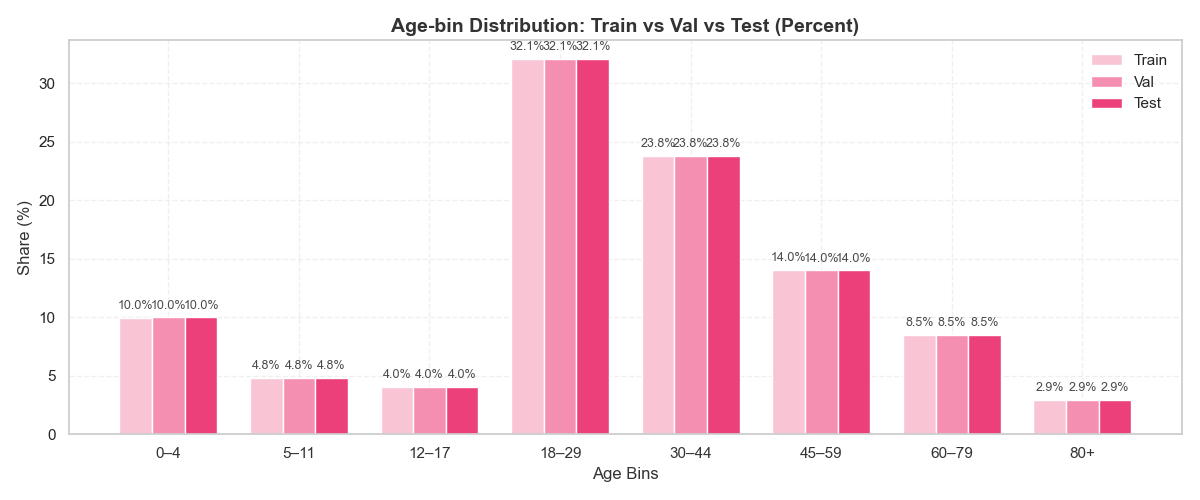

In [ ]:
# The RNG and normalization flag will be injected from the main preprocessing context
rng = None
NORMALIZE_01 = True

def set_augment_seed(random_generator, normalize=True):
    """
    Set the RNG object and normalization flag for augmentations.

    Parameters
    ----------
    random_generator : np.random.Generator
        RNG instance from preprocessing.
    normalize : bool
        Whether to normalize output images to [0,1] float32.
    """
    global rng, NORMALIZE_01
    rng = random_generator
    NORMALIZE_01 = normalize

In [ ]:
# --- Data Augmentation Utilities (RAM-based, on-the-fly) ---
# Set RNG and normalization from preprocessing
set_augment_seed(rng, NORMALIZE_01)

In [ ]:
def make_sample_weights(bins):
    """
    Compute per-sample weights inversely proportional to bin frequency.
    This helps rebalance the training process across age groups.

    Parameters
    ----------
    bins : array-like
        Age bin index for each sample.

    Returns
    -------
    np.ndarray
        Per-sample weights (float32) of same length as `bins`.
    """
    counts = Counter(bins)
    n = len(bins)
    K = len(counts)
    return np.array([n / (K * counts[b]) for b in bins], dtype=np.float32)

In [ ]:
# --- Compute inverse-frequency sample weights (per age bin) ---
train_weights = make_sample_weights(bins_train)
print("Example weights:", train_weights[:10])

Example weights: [0.38990846 1.2536415  0.52623534 4.3121166  0.38990846 1.2536415
 0.89235085 0.52623534 0.89235085 0.52623534]

In [ ]:
def plot_avg_sample_weight_per_bin(train_weights, bins_train, AGE_BINS, bar_color="#EC407A"):
    """
    Plot average inverse-frequency sample weight per age bin.

    Parameters
    ----------
    train_weights : array-like
        Per-sample weights computed via make_sample_weights().
    bins_train : array-like
        Age bin index for each sample in the training set.
    AGE_BINS : list[int]
        List of age bin edges.
    bar_color : str, optional
        Color of the bars. Default is a rosa-inspired pink.

    Returns
    -------
    bin_labels : list[str]
        Human-readable labels for each age bin.
    """
    unique_bins = sorted(set(bins_train))
    avg_weights = [train_weights[np.array(bins_train) == b].mean() for b in unique_bins]

    # Create human-readable bin labels
    bin_labels = []
    for i in unique_bins:
        lo, hi = AGE_BINS[i], AGE_BINS[i + 1]
        if i < len(AGE_BINS) - 2:
            bin_labels.append(f"{lo}–{hi - 1}")
        else:
            bin_labels.append(f"{lo}+")

    # Plot
    plt.figure(figsize=(10, 5))
    sns.set_theme(style="whitegrid")

    plt.bar(bin_labels, avg_weights, color=bar_color, alpha=0.8, edgecolor="white", linewidth=1.2)
    plt.xlabel("Age Bins", fontsize=12, color="#333333")
    plt.ylabel("Average Sample Weight", fontsize=12, color="#333333")
    plt.title("Inverse-Frequency Sample Weights per Age Bin",
              fontsize=14, color="#333333", weight="bold")
    plt.grid(axis="y", linestyle="--", alpha=0.3)

    # Add numeric labels above bars
    for i, v in enumerate(avg_weights):
        plt.text(i, v + (max(avg_weights) * 0.02), f"{v:.2f}",
                 ha='center', va='bottom', fontsize=9, color="#4A4A4A")

    plt.tight_layout()
    plt.show()

In [ ]:
# --- Visualize average sample weight per age bin ---
plot_avg_sample_weight_per_bin(train_weights=train_weights, bins_train=bins_train, AGE_BINS=AGE_BINS)

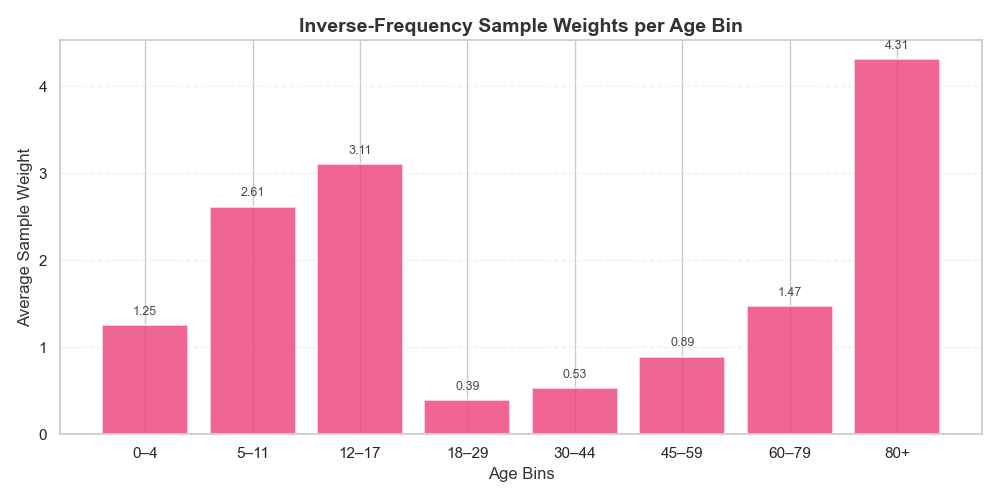

In [ ]:
# --- Augmentation functions ---
def random_hflip(img, p=0.5):
    if rng.random() < p:
        return np.ascontiguousarray(img[:, ::-1, :])
    return img


def random_rotate(img, max_deg=10):
    deg = float(rng.uniform(-max_deg, max_deg))
    h, w = img.shape[:2]
    M = cv2.getRotationMatrix2D((w / 2, h / 2), deg, 1.0)
    return cv2.warpAffine(img, M, (w, h), flags=cv2.INTER_LINEAR, borderMode=cv2.BORDER_REFLECT_101)


def random_crop_and_resize(img, scale=(0.88, 1.0)):
    h, w = img.shape[:2]
    s = float(rng.uniform(scale[0], scale[1]))
    new_h, new_w = int(h * s), int(w * s)
    max_y = max(h - new_h, 0)
    max_x = max(w - new_w, 0)
    y0 = int(rng.integers(0, max_y + 1)) if max_y > 0 else 0
    x0 = int(rng.integers(0, max_x + 1)) if max_x > 0 else 0
    crop = img[y0:y0 + new_h, x0:x0 + new_w, :]
    return cv2.resize(crop, (w, h), interpolation=cv2.INTER_AREA)


def random_brightness_contrast(img, b_lim=0.15, c_lim=0.15, p=0.8):
    if rng.random() > p:
        return img
    brightness = float(rng.uniform(-b_lim, b_lim))
    contrast = 1.0 + float(rng.uniform(-c_lim, c_lim))
    out = img * contrast + brightness
    return np.clip(out, 0.0, 1.0)


def add_gaussian_noise(img, sigma=0.02, p=0.3):
    if rng.random() > p:
        return img
    noise = rng.normal(0.0, sigma, img.shape).astype(np.float32)
    out = img + noise
    return np.clip(out, 0.0, 1.0)


def augment_once(img_uint8):
    """
    Apply random augmentations sequentially.
    Input: uint8 RGB image.
    Output: float32 RGB image, normalized to [0,1] if NORMALIZE_01=True.
    """
    y = random_hflip(img_uint8, p=0.5)
    y = random_rotate(y, max_deg=10)
    y = random_crop_and_resize(y, scale=(0.88, 1.0))
    y = y.astype(np.float32) / 255.0 if NORMALIZE_01 else y.astype(np.float32)
    y = random_brightness_contrast(y, b_lim=0.15, c_lim=0.15, p=0.8)
    y = add_gaussian_noise(y, sigma=0.02, p=0.3)
    return y

def train_batch_generator(X, y, batch_size, weights=None, shuffle=True):
    """
    Disk/memmap-safe batch generator with on-the-fly augmentation.
    Converts each sample individually to float32 for augmentation.
    """
    n = len(y)
    order = np.arange(n)

    while True:
        if shuffle:
            np.random.shuffle(order)
        for start in range(0, n, batch_size):
            sel = order[start:start + batch_size]
            bx = np.empty((len(sel),) + X.shape[1:], dtype=np.float32)

            for i, j in enumerate(sel):
                # X[j] is a memmap row (float16, normalized [0,1])
                img = (X[j] * 255.0).astype(np.uint8)
                aug = augment_once(img) # augment_once returns float32 normalized [0,1]
                bx[i] = aug

            by = y[sel]

            if weights is not None:
                bw = weights[sel]
                yield bx, by, bw
            else:
                yield bx, by

def val_batch_iterator(X, y, batch_size, normalize=True):
    """
    Disk/memmap-safe validation iterator (no augmentation, deterministic order).
    """
    n = len(y)
    for start in range(0, n, batch_size):
        sel = slice(start, start + batch_size)
        bx = X[sel].astype(np.float32)
        # X is already normalized [0,1] if loaded from memmap
        if not normalize:
            bx = (bx * 255.0)
        by = y[sel]
        yield bx, by

In [ ]:
# --- Batch Generators (RAM-based, on-the-fly augmentation) ---
# --- Batch generators using standardized ages ---
batch_size = 16
train_gen = train_batch_generator(X_train, y_train_std, batch_size=batch_size, weights=train_weights)
val_gen = val_batch_iterator(X_val, y_val_std, batch_size=batch_size)

# Create a small batch for visualization
dbg_gen = train_batch_generator(X_train, y_train_std, batch_size=batch_size, weights=train_weights)
dbg_batch = next(dbg_gen)

if len(dbg_batch) == 3:
    dbg_X, dbg_y_std, _ = dbg_batch
else:
    dbg_X, dbg_y_std = dbg_batch

In [ ]:
def plot_augmented_samples(batch_X, batch_y_raw, n_rows=2, n_cols=4, title="Augmented Sample Previews"):
    """
    Visualize a grid of augmented images from a batch.

    Parameters
    ----------
    batch_X : np.ndarray
        Batch of images (float32, normalized to [0,1]).
    batch_y_raw : array-like
        Corresponding raw labels (e.g., ages).
    n_rows : int
        Number of rows in the grid.
    n_cols : int
        Number of columns in the grid.
    title : str
        Figure title.
    """
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2.5, n_rows * 2.5), constrained_layout=True)
    fig.suptitle(title, fontsize=14, color="#333333", weight="bold", y=1.02)

    for ax, img, label in zip(axes.ravel(), batch_X, batch_y_raw):
        ax.imshow(np.clip(img, 0, 1))
        ax.set_title(f"Age: {int(label)}", fontsize=10, color="#4A4A4A", pad=4)
        ax.axis("off")

    plt.show()

In [ ]:
# Map to raw ages
dbg_y_raw = y_train[:len(dbg_y_std)]

# Plot augmented samples
plot_augmented_samples(dbg_X, dbg_y_raw)

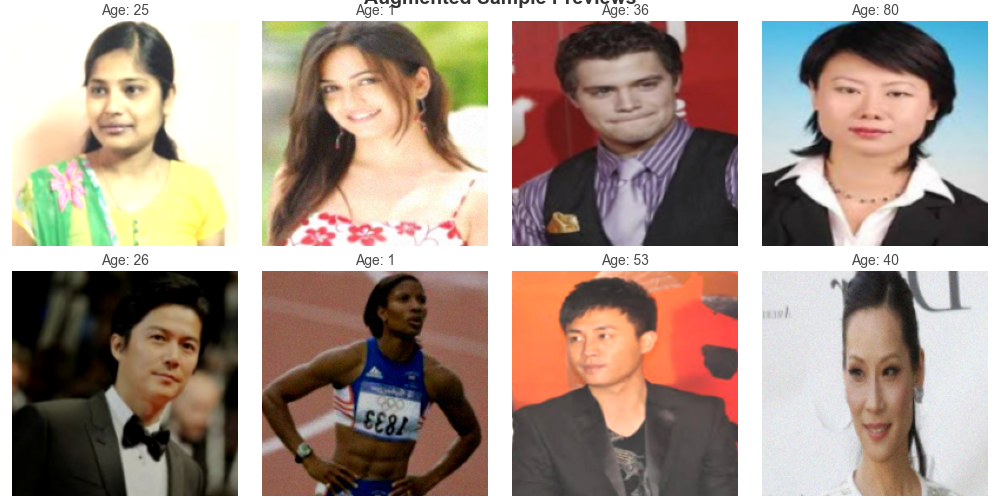

In [ ]:
from tensorflow.keras import layers, models, regularizers
import tensorflow as tf

def build_model(input_shape=(160, 160, 3)):
    """
    Builds and compiles the CNN model for age prediction.

    Returns:
        model (tf.keras.Model): compiled Keras model ready for training
    """
    model = models.Sequential([
        # Block 1
        layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(32, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.25),

        # Block 2
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(64, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.3),

        # Block 3
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.Conv2D(128, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.35),

        # Block 4
        layers.Conv2D(256, (3, 3), padding='same'),
        layers.BatchNormalization(),
        layers.LeakyReLU(alpha=0.1),
        layers.MaxPooling2D((2, 2)),
        layers.SpatialDropout2D(0.4),

        # Dense head
        layers.GlobalAveragePooling2D(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(1e-3)),
        layers.BatchNormalization(),
        layers.Dropout(0.4),
        # Output
        layers.Dense(1, activation='linear', dtype='float32')
    ])

    # Compile with Huber loss and Adam optimizer
    optimizer = tf.keras.optimizers.Adam(learning_rate=5e-4)
    model.compile(
        optimizer=optimizer,
        loss=tf.keras.losses.Huber(),
        metrics=[tf.keras.metrics.MeanAbsoluteError(name='mae'), 'mse']
    )

    return model

In [ ]:
# --- 4. Model Design & Implementation (RAM-based training ready) ---
model = build_model(input_shape=target_size + (3,))
model.summary()

Model: "sequential"
┌─────────────────────────────────┬────────────────────────┬───────────────┐
│ Layer (type)                    │ Output Shape           │       Param # │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 192, 192, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu (LeakyReLU)         │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 192, 192, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 192, 192, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_1 (LeakyReLU)       │ (None, 192, 192, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 96, 96, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d               │ (None, 96, 96, 32)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 96, 96, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 96, 96, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_1             │ (None, 48, 48, 64)     │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_4 (LeakyReLU)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_5 (LeakyReLU)       │ (None, 48, 48, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_2             │ (None, 24, 24, 128)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 24, 24, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ spatial_dropout2d_3             │ (None, 12, 12, 256)    │             0 │
│ (SpatialDropout2D)              │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │        16,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_8           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_9           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘
 Total params: 670,753 (2.56 MB)
 Trainable params: 668,641 (2.55 MB)
 Non-trainable params: 2,112 (8.25 KB)

In [ ]:
from tensorflow.keras import callbacks

def train_model(model, train_gen, val_gen, y_train_std, y_val_std,
                batch_size=16, epochs=50, save_path="./best_model/best_model.keras"):
    """
    Train the model with generators and callbacks.

    Returns:
        history: training history
        test_metrics: dict with standardized MAE/MSE and optionally raw MAE/MSE
    """

    steps_per_epoch = len(y_train_std) // batch_size
    validation_steps = len(y_val_std) // batch_size

    print(f"Training samples: {len(y_train_std)} | Validation samples: {len(y_val_std)}")
    print(f"Steps per epoch: {steps_per_epoch} | Validation steps: {validation_steps}")
    print(f"Batch size: {batch_size}")

    # --- Callbacks ---
    checkpoint_cb = callbacks.ModelCheckpoint(
        save_path,
        save_best_only=True,
        monitor="val_mae",
        mode="min"
    )

    reduce_lr_cb = callbacks.ReduceLROnPlateau(
        monitor="val_loss",
        factor=0.5,
        patience=7,
        min_lr=1e-6,
        verbose=1
    )

    early_stop_cb = callbacks.EarlyStopping(
        monitor="val_loss",
        patience=15,
        restore_best_weights=True
    )

    # --- Train the model ---
    history = model.fit(
        train_gen,
        steps_per_epoch=steps_per_epoch,
        validation_data=val_gen,
        validation_steps=validation_steps,
        epochs=epochs,
        callbacks=[checkpoint_cb, reduce_lr_cb, early_stop_cb],
        verbose=1
    )

    return history

In [ ]:
# --- 5. Training (RAM-based, on-the-fly augmentation) ---
# Train the model
history = train_model(
    model=model,
    train_gen=train_gen,
    val_gen=val_gen,
    y_train_std=y_train_std,
    y_val_std=y_val_std,
    batch_size=batch_size,
    epochs=50
)

Training samples: 16869 | Validation samples: 3615

Steps per epoch: 1054 | Validation steps: 225

Batch size: 16

Epoch 1/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2758s 3s/step - loss: 1.3743 - mae: 1.1376 - mse: 2.1209 - val_loss: 0.8194 - val_mae: 0.8018 - val_mse: 0.9867 - learning_rate: 5.0000e-04

Epoch 2/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.2042 - mae: 0.8883 - mse: 1.27882025-10-28 05:23:58.149182: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]

C:\Users\kayam\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\epoch_iterator.py:164: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2715s 3s/step - loss: 1.1824 - mae: 0.8657 - mse: 1.2222 - val_loss: 0.8163 - val_mae: 0.8233 - val_mse: 1.0024 - learning_rate: 5.0000e-04

Epoch 3/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.1434 - mae: 0.8221 - mse: 1.11222025-10-28 06:09:19.069600: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2721s 3s/step - loss: 1.1153 - mae: 0.8053 - mse: 1.0729 - val_loss: 0.8008 - val_mae: 0.8389 - val_mse: 1.0417 - learning_rate: 5.0000e-04

Epoch 4/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2723s 3s/step - loss: 1.0632 - mae: 0.7853 - mse: 1.0266 - val_loss: 0.7317 - val_mae: 0.8176 - val_mse: 0.9796 - learning_rate: 5.0000e-04

Epoch 5/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 1.0568 - mae: 0.7941 - mse: 1.04892025-10-28 07:40:04.795964: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2723s 3s/step - loss: 1.0068 - mae: 0.7808 - mse: 1.0166 - val_loss: 0.6563 - val_mae: 0.7838 - val_mse: 0.9257 - learning_rate: 5.0000e-04

Epoch 6/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2728s 3s/step - loss: 0.9391 - mae: 0.7734 - mse: 1.0028 - val_loss: 0.6220 - val_mae: 0.8121 - val_mse: 1.0079 - learning_rate: 5.0000e-04

Epoch 7/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2725s 3s/step - loss: 0.8847 - mae: 0.7769 - mse: 1.0054 - val_loss: 0.5510 - val_mae: 0.7808 - val_mse: 0.9414 - learning_rate: 5.0000e-04

Epoch 8/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2727s 3s/step - loss: 0.8305 - mae: 0.7753 - mse: 1.0056 - val_loss: 0.5374 - val_mae: 0.8059 - val_mse: 1.0415 - learning_rate: 5.0000e-04

Epoch 9/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.7929 - mae: 0.7683 - mse: 0.99812025-10-28 10:41:48.513087: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2722s 3s/step - loss: 0.7949 - mae: 0.7763 - mse: 1.0081 - val_loss: 0.5143 - val_mae: 0.8084 - val_mse: 1.0504 - learning_rate: 5.0000e-04

Epoch 10/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2325s 2s/step - loss: 0.7685 - mae: 0.7699 - mse: 0.9935 - val_loss: 0.4964 - val_mae: 0.7978 - val_mse: 1.0576 - learning_rate: 5.0000e-04

Epoch 11/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2675s 3s/step - loss: 0.7645 - mae: 0.7731 - mse: 0.9994 - val_loss: 0.4634 - val_mae: 0.7833 - val_mse: 0.9808 - learning_rate: 5.0000e-04

Epoch 12/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2721s 3s/step - loss: 0.7425 - mae: 0.7727 - mse: 0.9959 - val_loss: 0.4627 - val_mae: 0.7926 - val_mse: 0.9948 - learning_rate: 5.0000e-04

Epoch 13/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2743s 3s/step - loss: 0.7434 - mae: 0.7770 - mse: 1.0066 - val_loss: 0.4310 - val_mae: 0.7854 - val_mse: 0.9370 - learning_rate: 5.0000e-04

Epoch 14/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2242s 2s/step - loss: 0.7327 - mae: 0.7790 - mse: 1.0080 - val_loss: 0.4021 - val_mae: 0.7238 - val_mse: 0.8447 - learning_rate: 5.0000e-04

Epoch 15/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 1349s 1s/step - loss: 0.7372 - mae: 0.7769 - mse: 1.0087 - val_loss: 0.5168 - val_mae: 0.8733 - val_mse: 1.1805 - learning_rate: 5.0000e-04

Epoch 16/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2236s 2s/step - loss: 0.7288 - mae: 0.7746 - mse: 0.9985 - val_loss: 0.4064 - val_mae: 0.7172 - val_mse: 0.8730 - learning_rate: 5.0000e-04

Epoch 17/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 888ms/step - loss: 0.7153 - mae: 0.7726 - mse: 0.99182025-10-28 15:28:55.608777: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 937s 889ms/step - loss: 0.7239 - mae: 0.7750 - mse: 1.0005 - val_loss: 0.4002 - val_mae: 0.7310 - val_mse: 0.8644 - learning_rate: 5.0000e-04

Epoch 18/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2580s 2s/step - loss: 0.7179 - mae: 0.7790 - mse: 1.0055 - val_loss: 0.4376 - val_mae: 0.7640 - val_mse: 0.9501 - learning_rate: 5.0000e-04

Epoch 19/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2163s 2s/step - loss: 0.7112 - mae: 0.7729 - mse: 0.9984 - val_loss: 0.4173 - val_mae: 0.7715 - val_mse: 0.8766 - learning_rate: 5.0000e-04

Epoch 20/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2735s 3s/step - loss: 0.6993 - mae: 0.7694 - mse: 0.9888 - val_loss: 0.3130 - val_mae: 0.6223 - val_mse: 0.6109 - learning_rate: 5.0000e-04

Epoch 21/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2745s 3s/step - loss: 0.6999 - mae: 0.7768 - mse: 1.0056 - val_loss: 0.2690 - val_mae: 0.5826 - val_mse: 0.4985 - learning_rate: 5.0000e-04
Epoch 22/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2749s 3s/step - loss: 0.6898 - mae: 0.7687 - mse: 0.9886 - val_loss: 0.2785 - val_mae: 0.6023 - val_mse: 0.5167 - learning_rate: 5.0000e-04

Epoch 23/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2743s 3s/step - loss: 0.6853 - mae: 0.7714 - mse: 1.0002 - val_loss: 0.3330 - val_mae: 0.6697 - val_mse: 0.6564 - learning_rate: 5.0000e-04

Epoch 24/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2055s 2s/step - loss: 0.6787 - mae: 0.7640 - mse: 0.9823 - val_loss: 0.3764 - val_mae: 0.7231 - val_mse: 0.7624 - learning_rate: 5.0000e-04

Epoch 25/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2554s 2s/step - loss: 0.6723 - mae: 0.7638 - mse: 0.9801 - val_loss: 0.2782 - val_mae: 0.6063 - val_mse: 0.5201 - learning_rate: 5.0000e-04

Epoch 26/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2698s 3s/step - loss: 0.6751 - mae: 0.7732 - mse: 0.9980 - val_loss: 0.2938 - val_mae: 0.6308 - val_mse: 0.5788 - learning_rate: 5.0000e-04

Epoch 27/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2740s 3s/step - loss: 0.6489 - mae: 0.7674 - mse: 0.9792 - val_loss: 0.4250 - val_mae: 0.7844 - val_mse: 0.8879 - learning_rate: 5.0000e-04

Epoch 28/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.6537 - mae: 0.7677 - mse: 0.9850

Epoch 28: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2548s 2s/step - loss: 0.6552 - mae: 0.7681 - mse: 0.9878 - val_loss: 0.3289 - val_mae: 0.6779 - val_mse: 0.6445 - learning_rate: 5.0000e-04

Epoch 29/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2720s 3s/step - loss: 0.6344 - mae: 0.7521 - mse: 0.9538 - val_loss: 0.3439 - val_mae: 0.6931 - val_mse: 0.6991 - learning_rate: 2.5000e-04

Epoch 30/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2762s 3s/step - loss: 0.6181 - mae: 0.7553 - mse: 0.9577 - val_loss: 0.2719 - val_mae: 0.5782 - val_mse: 0.5354 - learning_rate: 2.5000e-04

Epoch 31/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2745s 3s/step - loss: 0.6110 - mae: 0.7527 - mse: 0.9543 - val_loss: 0.3158 - val_mae: 0.6526 - val_mse: 0.6384 - learning_rate: 2.5000e-04

Epoch 32/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2740s 3s/step - loss: 0.6041 - mae: 0.7495 - mse: 0.9487 - val_loss: 0.2594 - val_mae: 0.5983 - val_mse: 0.5192 - learning_rate: 2.5000e-04

Epoch 33/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - loss: 0.6011 - mae: 0.7487 - mse: 0.95132025-10-29 03:09:27.918954: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2755s 3s/step - loss: 0.5992 - mae: 0.7487 - mse: 0.9473 - val_loss: 0.3144 - val_mae: 0.6400 - val_mse: 0.6412 - learning_rate: 2.5000e-04

Epoch 34/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2761s 3s/step - loss: 0.5889 - mae: 0.7540 - mse: 0.9552 - val_loss: 0.3439 - val_mae: 0.7243 - val_mse: 0.6891 - learning_rate: 2.5000e-04

Epoch 35/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2761s 3s/step - loss: 0.5879 - mae: 0.7507 - mse: 0.9490 - val_loss: 0.3149 - val_mae: 0.6623 - val_mse: 0.6329 - learning_rate: 2.5000e-04

Epoch 36/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2767s 3s/step - loss: 0.5728 - mae: 0.7434 - mse: 0.9334 - val_loss: 0.2729 - val_mae: 0.6025 - val_mse: 0.5388 - learning_rate: 2.5000e-04

Epoch 37/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2755s 3s/step - loss: 0.5770 - mae: 0.7479 - mse: 0.9451 - val_loss: 0.2570 - val_mae: 0.5843 - val_mse: 0.5005 - learning_rate: 2.5000e-04

Epoch 38/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2758s 3s/step - loss: 0.5752 - mae: 0.7455 - mse: 0.9448 - val_loss: 0.2673 - val_mae: 0.5933 - val_mse: 0.5307 - learning_rate: 2.5000e-04

Epoch 39/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2782s 3s/step - loss: 0.5644 - mae: 0.7377 - mse: 0.9175 - val_loss: 0.2393 - val_mae: 0.5713 - val_mse: 0.4523 - learning_rate: 2.5000e-04

Epoch 40/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2811s 3s/step - loss: 0.5660 - mae: 0.7453 - mse: 0.9335 - val_loss: 0.3730 - val_mae: 0.7389 - val_mse: 0.7656 - learning_rate: 2.5000e-04

Epoch 41/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2822s 3s/step - loss: 0.5603 - mae: 0.7425 - mse: 0.9266 - val_loss: 0.2974 - val_mae: 0.6080 - val_mse: 0.5982 - learning_rate: 2.5000e-04

Epoch 42/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2820s 3s/step - loss: 0.5569 - mae: 0.7392 - mse: 0.9268 - val_loss: 0.3510 - val_mae: 0.6725 - val_mse: 0.7453 - learning_rate: 2.5000e-04

Epoch 43/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2664s 3s/step - loss: 0.5558 - mae: 0.7333 - mse: 0.9119 - val_loss: 0.2129 - val_mae: 0.4982 - val_mse: 0.3999 - learning_rate: 2.5000e-04

Epoch 44/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2725s 3s/step - loss: 0.5564 - mae: 0.7394 - mse: 0.9155 - val_loss: 0.2531 - val_mae: 0.5641 - val_mse: 0.4923 - learning_rate: 2.5000e-04

Epoch 45/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2595s 2s/step - loss: 0.5542 - mae: 0.7461 - mse: 0.9317 - val_loss: 0.2805 - val_mae: 0.5964 - val_mse: 0.5475 - learning_rate: 2.5000e-04

Epoch 46/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2804s 3s/step - loss: 0.5378 - mae: 0.7362 - mse: 0.9078 - val_loss: 0.2441 - val_mae: 0.5565 - val_mse: 0.4692 - learning_rate: 2.5000e-04

Epoch 47/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2788s 3s/step - loss: 0.5458 - mae: 0.7365 - mse: 0.9131 - val_loss: 0.3162 - val_mae: 0.6421 - val_mse: 0.6466 - learning_rate: 2.5000e-04

Epoch 48/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2777s 3s/step - loss: 0.5359 - mae: 0.7278 - mse: 0.9039 - val_loss: 0.2656 - val_mae: 0.5892 - val_mse: 0.5176 - learning_rate: 2.5000e-04

Epoch 49/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2651s 3s/step - loss: 0.5421 - mae: 0.7303 - mse: 0.9022 - val_loss: 0.4114 - val_mae: 0.7392 - val_mse: 0.9134 - learning_rate: 2.5000e-04

Epoch 50/50

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - loss: 0.5376 - mae: 0.7308 - mse: 0.9019

Epoch 50: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.

1054/1054 ━━━━━━━━━━━━━━━━━━━━ 2592s 2s/step - loss: 0.5387 - mae: 0.7321 - mse: 0.9100 - val_loss: 0.2260 - val_mae: 0.4948 - val_mse: 0.4370 - learning_rate: 2.5000e-04

113/113 ━━━━━━━━━━━━━━━━━━━━ 53s 465ms/step - loss: 0.3267 - mae: 0.6499 - mse: 0.7193

In [ ]:
def plot_training_history(history, title_suffix=""):
    """
    Plot loss and MAE curves from model training history.
    """
    plt.figure(figsize=(14, 6))

    train_color = "#F48FB1"
    val_color = "#F9C5D5"

    # Loss Curve
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss', color=train_color, linewidth=2)
    plt.plot(history.history['val_loss'], label='Validation Loss', color=val_color, linewidth=2)
    plt.title(f'Loss Curve {title_suffix}', fontsize=14, weight='bold', color="#4A4A4A")
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MAE Loss', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    # MAE Curve
    plt.subplot(1, 2, 2)
    plt.plot(history.history['mae'], label='Train MAE', color=train_color, linewidth=2)
    plt.plot(history.history['val_mae'], label='Validation MAE', color=val_color, linewidth=2)
    plt.title(f'MAE Curve {title_suffix}', fontsize=14, weight='bold', color="#4A4A4A")
    plt.xlabel('Epoch', fontsize=12)
    plt.ylabel('MAE', fontsize=12)
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.3)

    plt.tight_layout()
    plt.show()

In [ ]:
# Plot training curves
plot_training_history(history)

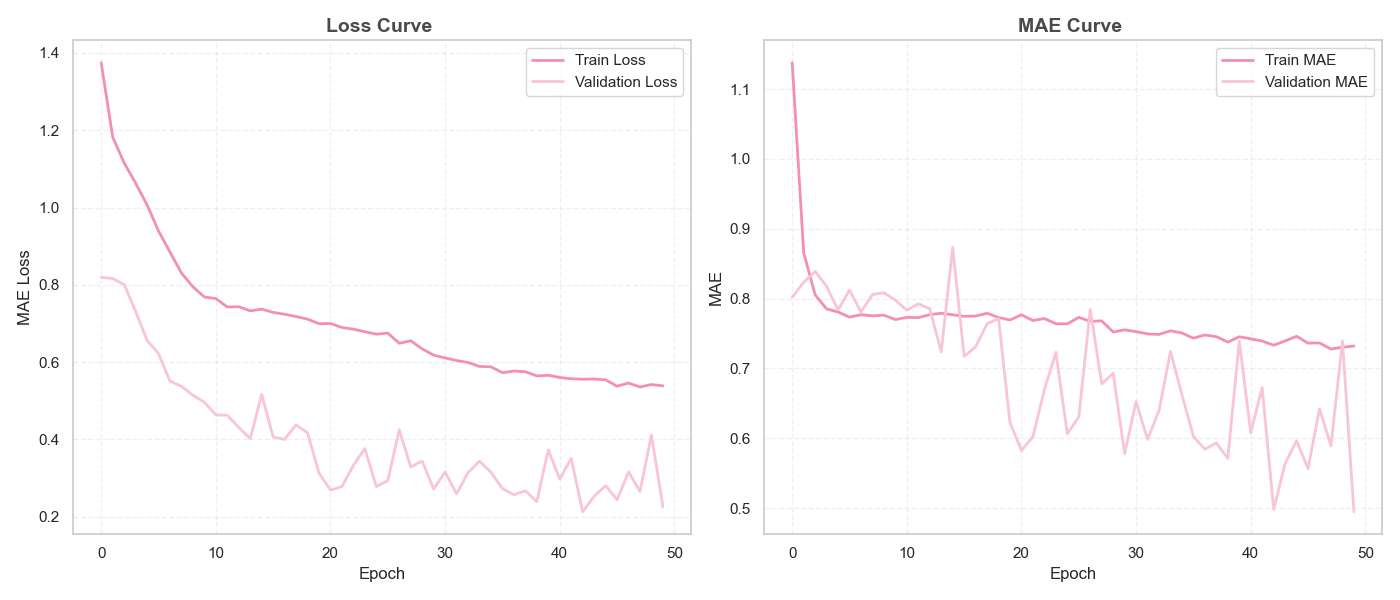

In [ ]:
def evaluate_model_on_test(model, X_test, y_test_std, age_mean, age_std, history=None, normalize=True, verbose=True):
    """
    Evaluate the model on the test set with standardized labels,
    and compute raw (interpretable) MAE and MSE.

    Args:
        model: Trained Keras model.
        X_test: Test images (numpy array).
        y_test_std: Standardized target labels (numpy array).
        age_mean: Mean used for standardization.
        age_std: Std used for standardization.
        history: Optional Keras History object for printing summary stats.
        normalize: Whether X_test is already normalized to [0,1].
        verbose: Print results if True.

    Returns:
        dict with standardized and raw metrics:
            {
                'test_loss': float,
                'test_mae': float,
                'test_mse': float,
                'raw_mae': float,
                'raw_mse': float
            }
    """
    # Ensure float32 input
    X_test_array = X_test.astype(np.float32)
    y_test_array = y_test_std

    # Evaluate standardized metrics
    test_loss, test_mae, test_mse = model.evaluate(X_test_array, y_test_array, verbose=verbose)

    # Convert predictions back to raw ages
    y_pred_std = model.predict(X_test_array, verbose=0)
    y_pred_raw = y_pred_std * age_std + age_mean
    y_test_raw  = y_test_array * age_std + age_mean

    # Raw MAE/MSE
    raw_mae = np.mean(np.abs(y_pred_raw.flatten() - y_test_raw.flatten()))
    raw_mse = np.mean((y_pred_raw.flatten() - y_test_raw.flatten())**2)

    if verbose:
        print(f"\n--- Test Set Evaluation ---")
        print(f"Standardized MAE (model output): {test_mae:.4f}")
        print(f"Standardized MSE: {test_mse:.4f}")
        print(f"Raw MAE: {raw_mae:.2f} years")
        print(f"Raw MSE: {raw_mse:.2f}")
        if history is not None:
            print(f"\nTraining epochs: {len(history.history['loss'])}")
            print(f"Min validation MAE: {min(history.history['val_mae']):.4f} (standardized)")

In [ ]:
evaluate_model_on_test(
    model=model,
    X_test=X_test,
    y_test_std=y_test_std,
    age_mean=age_mean,
    age_std=age_std,
    history=history,
    normalize=True,
    verbose=True
)

--- Test Set Evaluation ---

Standardized MAE (model output): 0.6499

Standardized MSE: 0.7193

Raw MAE: 13.11 years

Raw MSE: 292.56


Training epochs: 50

Min validation MAE: 0.4948 (standardized)

Corrupt JPEG data: bad Huffman code

Corrupt JPEG data: premature end of data segment

libpng warning: iCCP: known incorrect sRGB profile


Process finished with exit code 0

In [ ]:
# THE FOLLOWING CODE WASN'T TAILORED FOR THE PIPELINE/WORKFLOW FROM ABOVE, that is why it might seem out of place.

import math
from tensorflow.keras.models import load_model
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# ---------------------------
# Configuration
# ---------------------------
IMAGE_DIR = "data/images"
MODEL_PATH = "best_model/best_model.keras"
OUTPUT_DIR = "evaluation"
RANDOM_SEED = 84
SAMPLE_FRACTION = 0.15        # ~15% of all images
TARGET_SIZE = (160, 160)
NORMALIZE_01 = True
BATCH_SIZE = 32
AGE_BINS = [0, 5, 12, 18, 30, 45, 60, 80, 200]
SHOW_WORST_N = 8

# ---------------------------
# Create output directory
os.makedirs(OUTPUT_DIR, exist_ok=True)

# For reproducibility
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
sns.set_theme(style="whitegrid")

# You may want to add a simple print statement here instead of the logger.info line
print("Starting evaluation script.")

# ---------------------------
# Utility: parse filename to metadata
# filename format expected: age_gender_race_date(...).ext
# ---------------------------
def parse_filename_meta(fname):
    base = os.path.splitext(fname)[0]
    parts = base.split("_")
    if len(parts) < 3:
        return None
    try:
        age = int(parts[0])
        gender = int(parts[1])
        race = int(parts[2])
    except Exception:
        return None
    return {"filename": fname, "age": age, "gender": gender, "race": race}

# ---------------------------
# 1) Load model
# ---------------------------
print("Loading model: %s" % MODEL_PATH) # Replaced logger.info with print
model = load_model(MODEL_PATH)

# ensure model is built (helps Sequential models)
_dummy = np.zeros((1, TARGET_SIZE[1], TARGET_SIZE[0], 3), dtype=np.float32)
if NORMALIZE_01:
    _dummy /= 255.0
try:
    _ = model.predict(_dummy, verbose=0)
except Exception:
    # ignore if already built
    pass

# ---------------------------
# 2) Load test set using memmap + saved split
# ---------------------------
# Load split info
with open("dataset_split/dataset_split_info.pkl", "rb") as f:
    split_info = pickle.load(f)

idx_test = split_info["idx_test"]
age_mean = split_info["age_mean"]
age_std = split_info["age_std"]

# Paths for memmap files
size_tag = f"{TARGET_SIZE[0]}x{TARGET_SIZE[1]}"
X_path = f"data/memmap/X_resized_{size_tag}.dat"
y_path = f"data/memmap/y_resized_{size_tag}.dat"

# Infer total number of samples (from split indices)
n_samples = len(split_info["idx_train"]) + len(split_info["idx_val"]) + len(split_info["idx_test"])

# Load memmap arrays (read-only)
X_all = np.memmap(X_path, dtype=np.float16, mode="r",
                  shape=(n_samples, TARGET_SIZE[1], TARGET_SIZE[0], 3))
y_all = np.memmap(y_path, dtype=np.float32, mode="r", shape=(n_samples,))

# Extract test set
X_test = X_all[idx_test].astype(np.float32)
y_real = np.array(y_all[idx_test], dtype=np.float32)

# Standardize target (for models trained on standardized ages)
y_std = (y_real - age_mean) / age_std

print("Loaded test set from memmap: %d images", X_test.shape[0])

# Reconstruct metadata dataframe
meta_list = []
for i in idx_test:
    fname = sorted(os.listdir(IMAGE_DIR))[i]
    meta = parse_filename_meta(fname)
    if meta is not None:
        meta_list.append(meta)
meta_df = pd.DataFrame(meta_list)

# ---------------------------
# 3) Model predictions (no augmentation)
# ---------------------------
print("Predicting on test set...")
y_pred_std = model.predict(X_test, batch_size=BATCH_SIZE, verbose=1).flatten()

# Denormalize predictions back to real ages
y_pred = y_pred_std * age_std + age_mean

# Basic metrics (use real ages)
mae = mean_absolute_error(y_real, y_pred)
mse = mean_squared_error(y_real, y_pred)
rmse = math.sqrt(mse)
r2 = r2_score(y_real, y_pred)

print("=== Basic Metrics (Real Ages) ===")
print("MAE  : %.4f years", mae)
print("MSE  : %.4f", mse)
print("RMSE : %.4f", rmse)
print("R²   : %.4f", r2)

=== Basic Metrics (Real Ages) ===

Total images evaluated: 3615

MAE  : 13.533590 years

MSE  : 304.360931 (years²)

RMSE : 17.445943 years

R²   : 0.248410

In [ ]:
# Save CSV of predictions
results_df = meta_df.copy()
results_df["true_age_real"] = y_real
results_df["true_age_std"] = y_std
results_df["pred_age_real"] = y_pred
results_df["pred_age_std"] = y_pred_std
results_df["error_real"] = y_pred - y_real
results_df["abs_error_real"] = np.abs(results_df["error_real"])

csv_path = os.path.join(OUTPUT_DIR, "test_predictions.csv")
results_df.to_csv(csv_path, index=False)
print("Saved predictions to %s", csv_path)

# ---------------------------
# 4) Visualizations & Analyses (saved to OUTPUT_DIR)
# ---------------------------
def savefig(pth):
    try:
        plt.savefig(pth, dpi=150, bbox_inches="tight")
        print("Saved plot: %s", pth)
    except Exception as e:
        print("Failed to save plot %s: %s", pth, str(e))
    finally:
        plt.close()

# 4a: Scatter plot — Predicted vs True (real ages)
plt.figure(figsize=(7,7))
plt.scatter(y_real, y_pred, s=20, alpha=0.5, edgecolor="w", linewidth=0.7)
lims = [0, max(y_real.max(), y_pred.max()) + 5]
plt.plot(lims, lims, 'k--', alpha=0.7, label="Ideal = Perfect Prediction")
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("True Age (years)", fontsize=12)
plt.ylabel("Predicted Age (years)", fontsize=12)
plt.title("Predicted vs True Age (Test Set)", fontsize=14, weight="bold")
plt.grid(True, linestyle="--", alpha=0.3)
plt.legend()
plt.tight_layout()
savefig(os.path.join(OUTPUT_DIR, "pred_vs_true_scatter.png"))

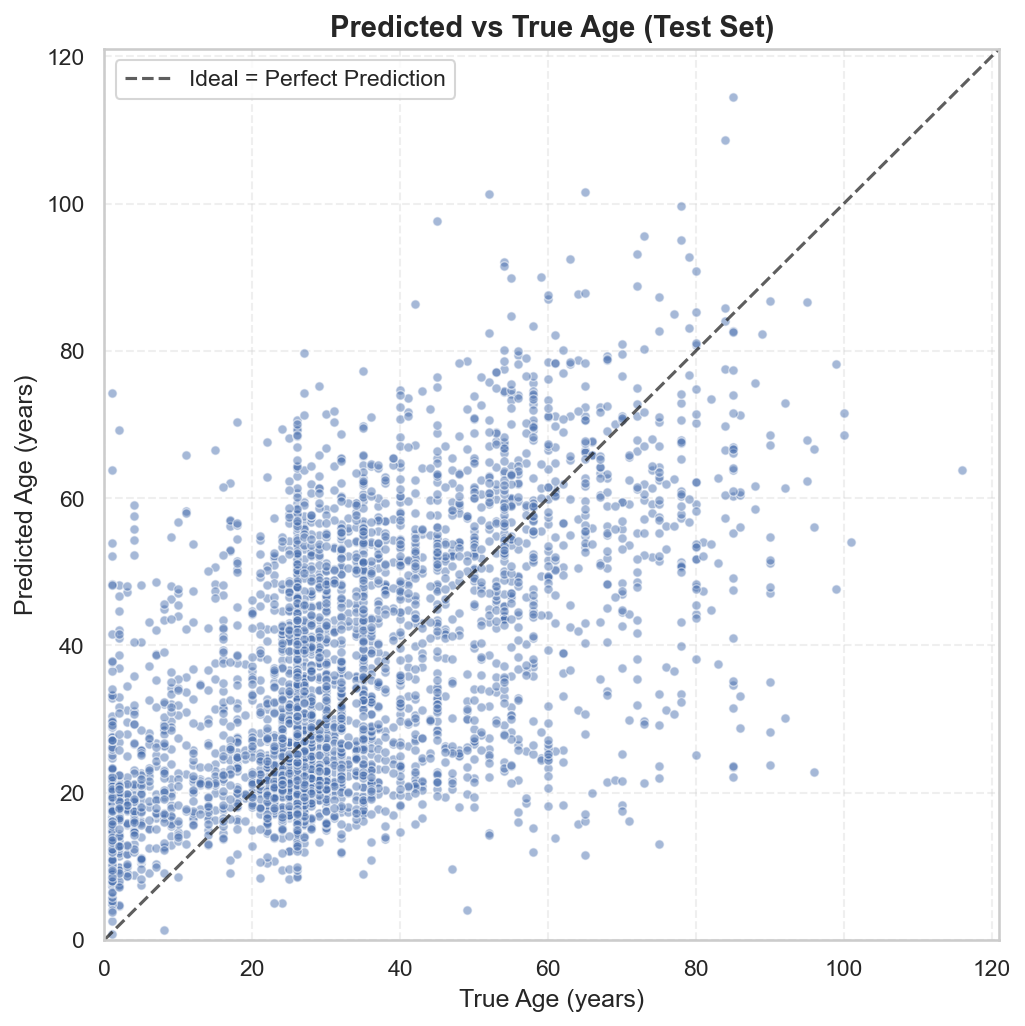

In [ ]:
# 4a (alt): Hexbin density
plt.figure(figsize=(7,7))
hb = plt.hexbin(y_real, y_pred, gridsize=50, cmap="Reds", mincnt=1)
cb = plt.colorbar(hb)
cb.set_label("Counts")
plt.plot(lims, lims, 'k--', alpha=0.7)
plt.xlim(lims)
plt.ylim(lims)
plt.xlabel("True Age (years)", fontsize=12)
plt.ylabel("Predicted Age (years)", fontsize=12)
plt.title("Predicted vs True Age (Hexbin Density)", fontsize=14, weight="bold")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
savefig(os.path.join(OUTPUT_DIR, "pred_vs_true_density.png"))

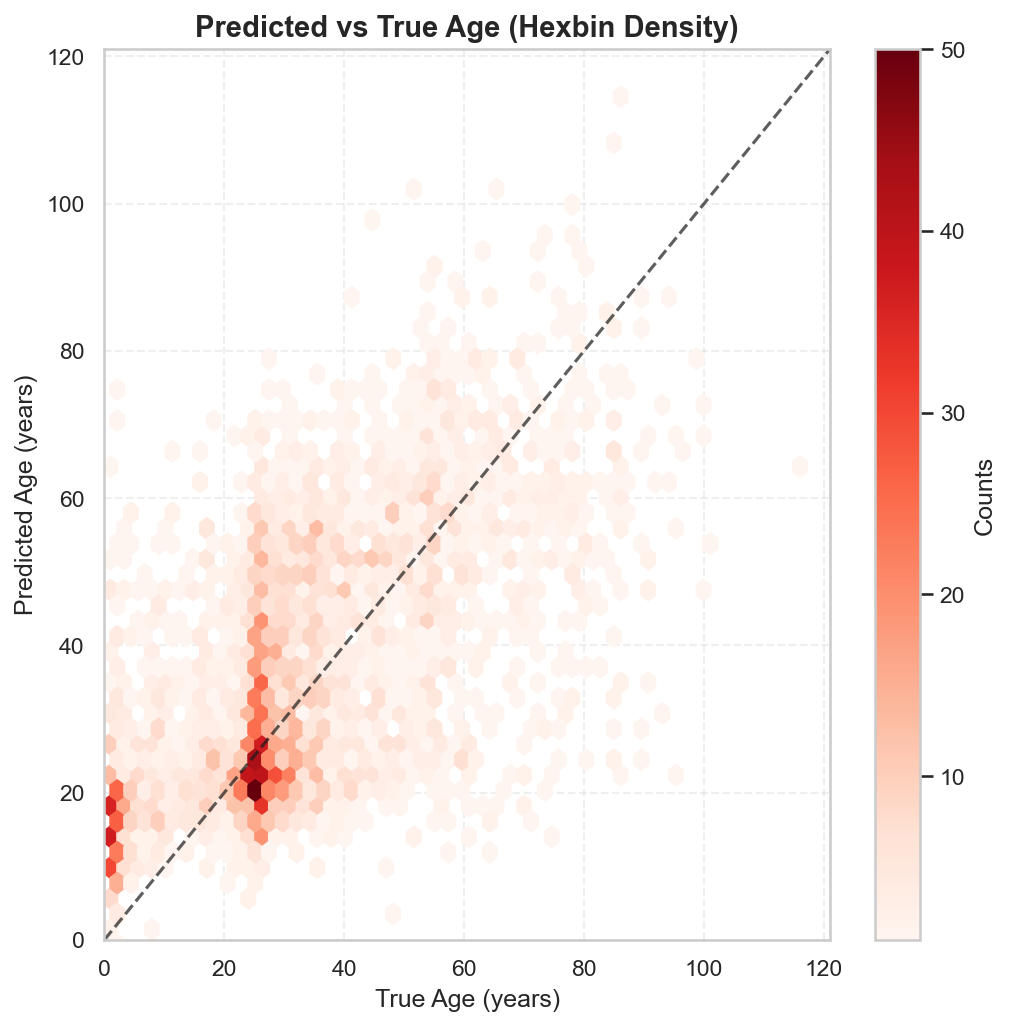

In [ ]:
# 4b: Residuals vs true age (real age units)
residuals = y_pred - y_real
plt.figure(figsize=(8,5))
plt.scatter(y_real, residuals, alpha=0.5, s=20, edgecolor="w")
plt.axhline(0, color='k', linestyle='--', alpha=0.6)
plt.xlabel("True Age (years)", fontsize=12)
plt.ylabel("Prediction Error (Predicted - True) [years]", fontsize=12)
plt.title("Residuals vs True Age", fontsize=14, weight="bold")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
savefig(os.path.join(OUTPUT_DIR, "residuals_vs_age.png"))

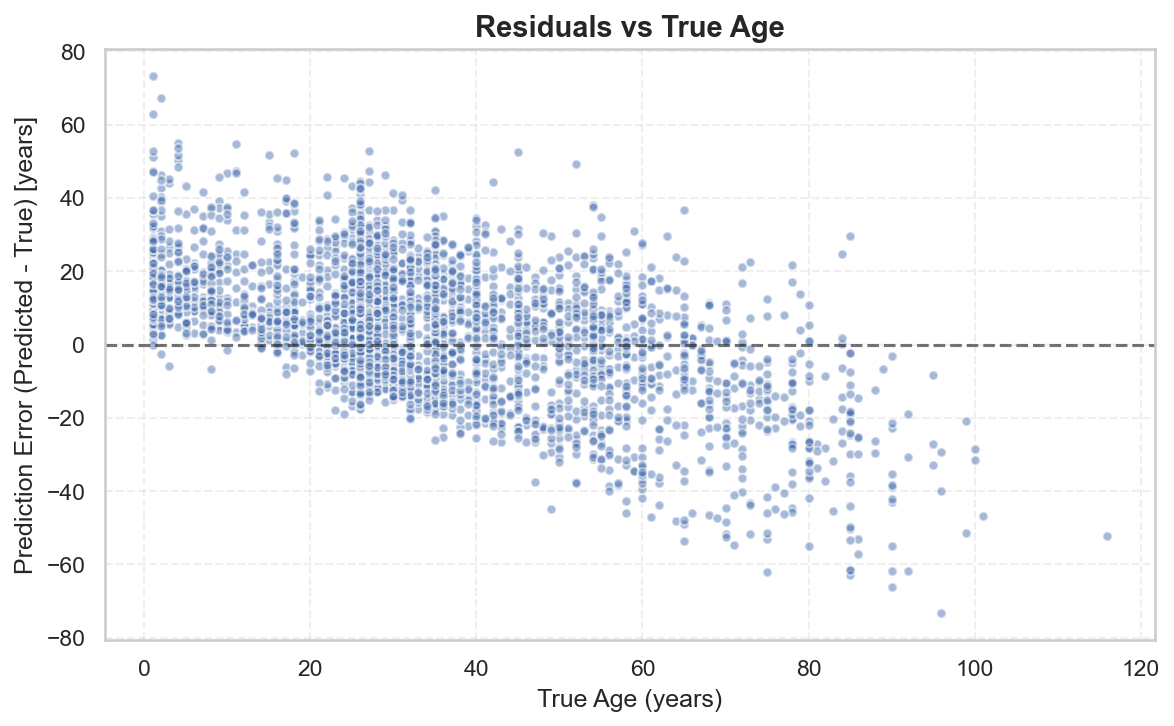

In [ ]:
# 4c: Residual histogram (real-age residuals)
plt.figure(figsize=(8,5))
sns.histplot(residuals, bins=40, kde=True, color="#FF8A65")
plt.xlabel("Residual (Predicted - True) [years]", fontsize=12)
plt.ylabel("Count", fontsize=12)
plt.title("Distribution of Prediction Residuals (Errors in Years)", fontsize=14, weight="bold")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
savefig(os.path.join(OUTPUT_DIR, "residual_histogram.png"))

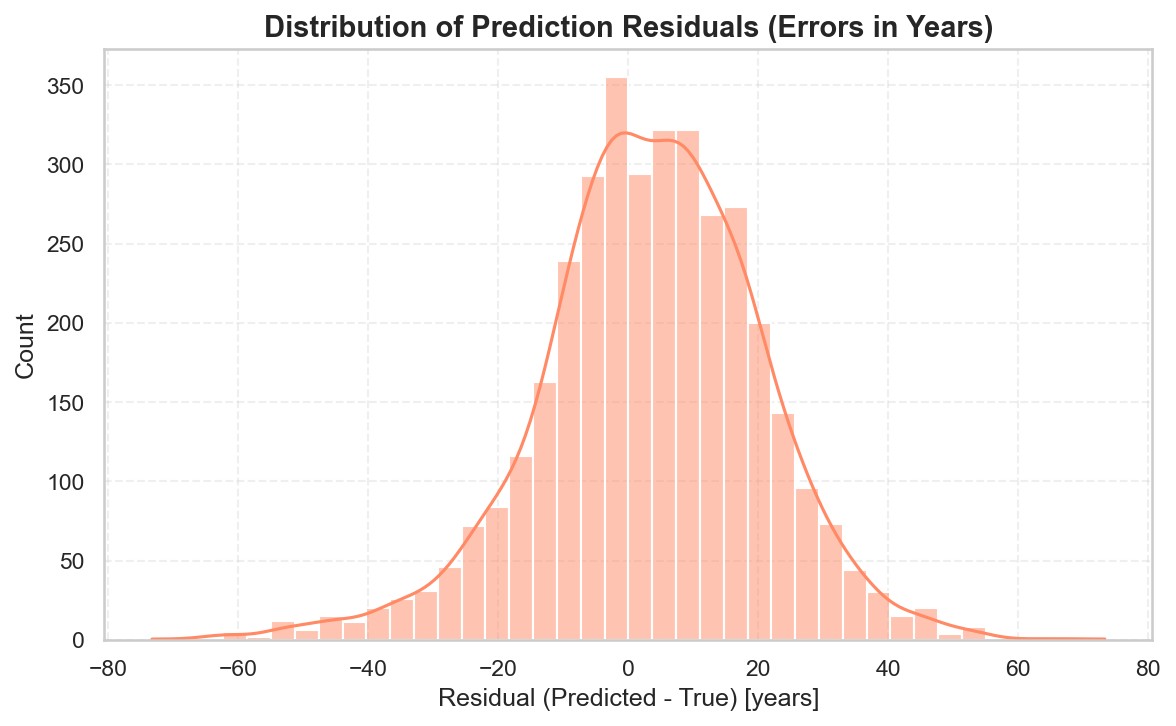

In [ ]:
# 4d: Mean Absolute Error per real-age bin
bin_idx = np.digitize(y_real, AGE_BINS, right=False) - 1
bin_labels = []
bin_mae = []
for i in range(len(AGE_BINS)-1):
    lo, hi = AGE_BINS[i], AGE_BINS[i+1]
    mask = bin_idx == i
    if np.any(mask):
        bin_mae.append(np.mean(np.abs(y_pred[mask] - y_real[mask])))
    else:
        bin_mae.append(np.nan)
    if i < len(AGE_BINS)-2:
        bin_labels.append(f"{lo}–{hi-1}")
    else:
        bin_labels.append(f"{lo}+")
plt.figure(figsize=(10,5))
sns.barplot(x=bin_labels, y=bin_mae, palette="rocket")
plt.xlabel("Age Bin (years)", fontsize=12)
plt.ylabel("Mean Absolute Error (years)", fontsize=12)
plt.title("Mean Absolute Error per Age Bin", fontsize=14, weight="bold")
plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
savefig(os.path.join(OUTPUT_DIR, "mae_per_age_bin.png"))

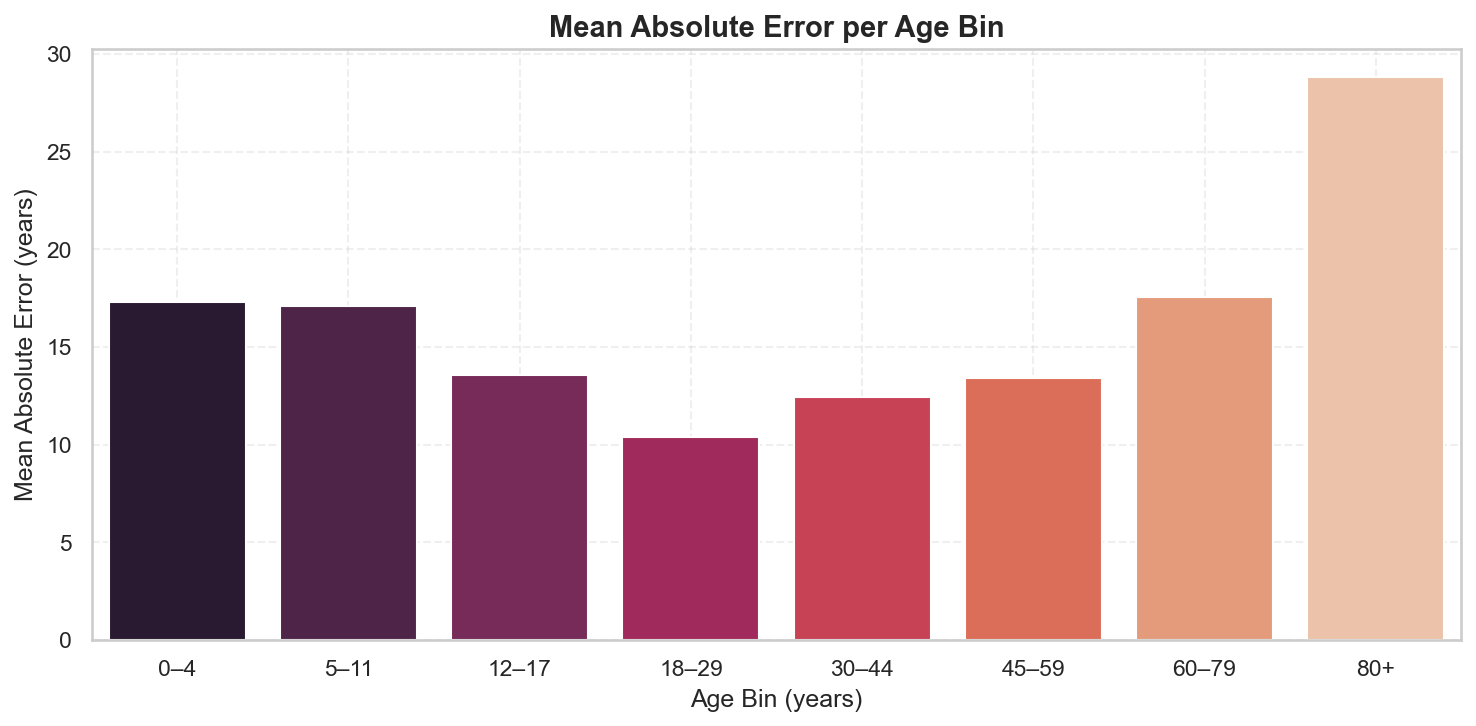

In [ ]:
# 4e: Hardest / worst predictions (real-age values)
worst_idx = np.argsort(-results_df["abs_error_real"].values)[:SHOW_WORST_N]
plt.figure(figsize=(12, 6))
for i, idx in enumerate(worst_idx):
    ax = plt.subplot(2, (SHOW_WORST_N+1)//2, i+1)
    img = X_test[idx]
    if NORMALIZE_01:
        img = np.clip(img, 0, 1)
    ax.imshow(img)
    true_age = results_df.loc[idx, "true_age_real"]
    pred_age = results_df.loc[idx, "pred_age_real"]
    abs_err = results_df.loc[idx, "abs_error_real"]
    ax.set_title(f"T:{true_age:.1f} / P:{pred_age:.1f}\nΔ={abs_err:.1f}", fontsize=10)
    ax.axis("off")
plt.suptitle("Hardest Predictions (Largest Absolute Errors in Years)", fontsize=14, weight="bold")
plt.tight_layout()
savefig(os.path.join(OUTPUT_DIR, "hardest_predictions.png"))

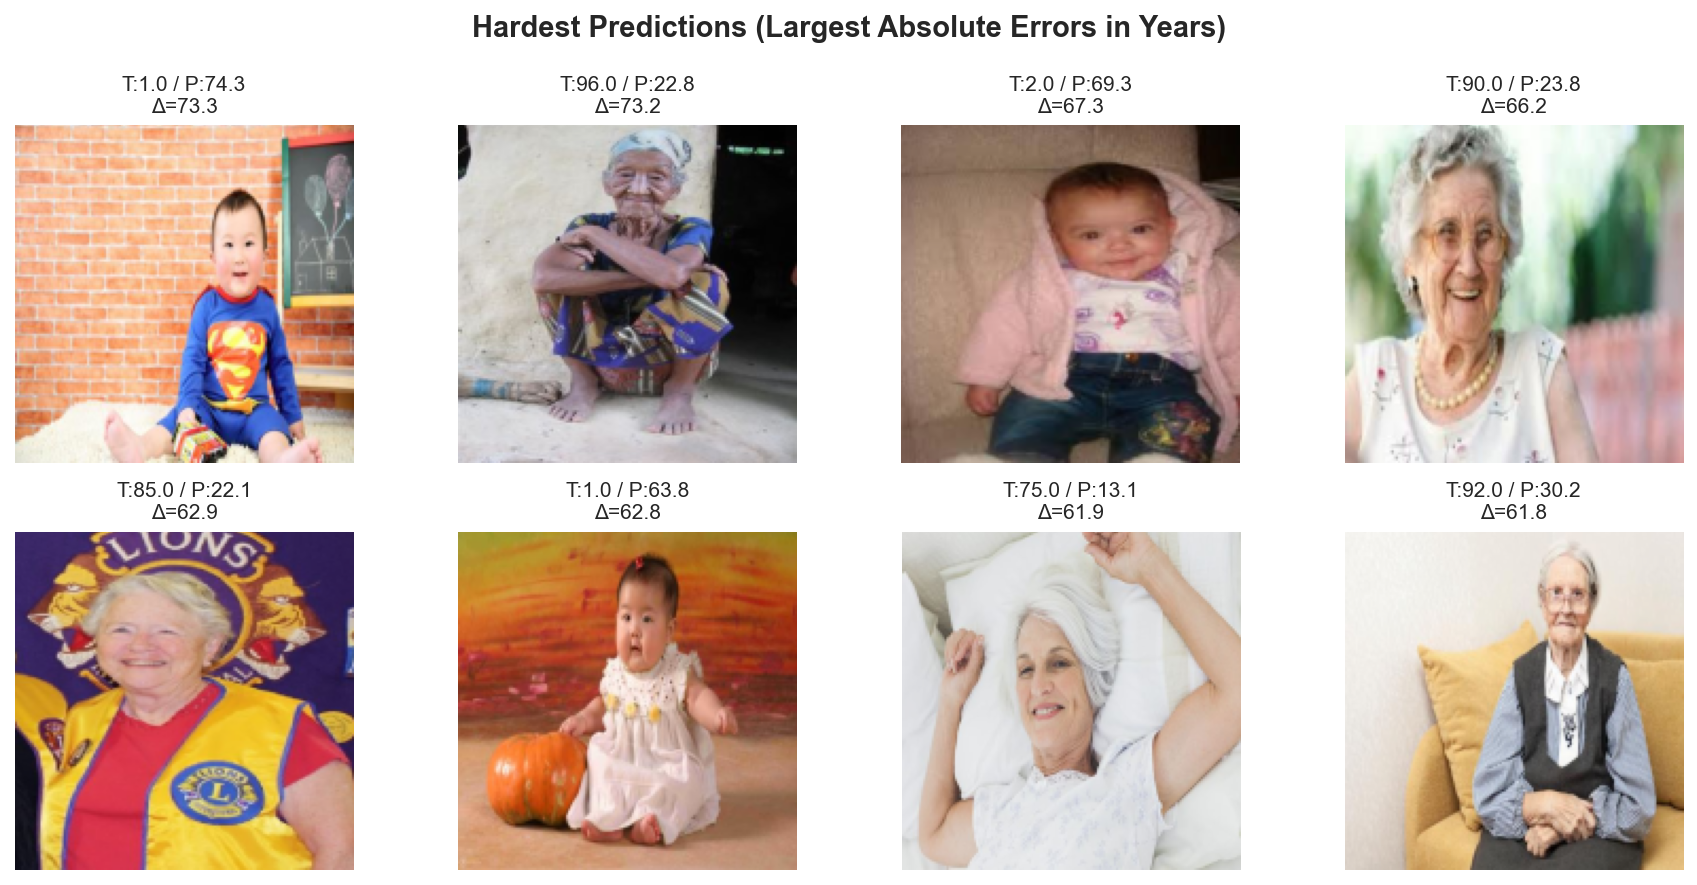

In [ ]:
# 4f: Summary statistics file (real-age evaluation)
summary_path = os.path.join(OUTPUT_DIR, "results_summary.txt")
with open(summary_path, "w", encoding="utf-8") as f:
    f.write("=== Test Set Evaluation Summary (Real Ages) ===\n")
    f.write(f"Total images evaluated: {len(y_real)}\n")
    f.write(f"MAE  : {mae:.6f} years\n")
    f.write(f"MSE  : {mse:.6f} (years²)\n")
    f.write(f"RMSE : {rmse:.6f} years\n")
    f.write(f"R²   : {r2:.6f}\n")

print("Saved summary to %s", summary_path)

=== Test Set Evaluation Summary (Real Ages) ===

Total images evaluated: 3615

MAE  : 13.533590 years

MSE  : 304.360931 (years²)

RMSE : 17.445943 years

R²   : 0.248410

In [ ]:
# ---------------------------
# 5) Demographic Bias Analysis (Gender & Race)
# ---------------------------
gender_map = {0: "Male", 1: "Female"}
race_map = {0: "White", 1: "Black", 2: "Asian", 3: "Indian", 4: "Other"}

demo_df = results_df.copy()

# Ensure gender and race metadata exist
if "gender" not in demo_df.columns or "race" not in demo_df.columns:
    if "gender" in meta_df.columns and "race" in meta_df.columns:
        demo_df["gender"] = meta_df["gender"].values
        demo_df["race"] = meta_df["race"].values
    else:
        print("Gender/race metadata missing — demographic bias plots may be incomplete.")

# Human-readable labels
demo_df["gender_str"] = demo_df["gender"].map(gender_map).fillna(demo_df["gender"].astype(str))
demo_df["race_str"] = demo_df["race"].map(race_map).fillna(demo_df["race"].astype(str))

# --- Gender-level statistics ---
gender_stats = demo_df.groupby("gender_str").agg(
    MAE=("abs_error_real", "mean"),
    RMSE=("abs_error_real", lambda x: math.sqrt(np.mean(x**2))),
    Count=("abs_error_real", "count")
).reset_index()

gender_stats_path = os.path.join(OUTPUT_DIR, "gender_error_stats.csv")
gender_stats.to_csv(gender_stats_path, index=False)
print("Saved gender error stats to %s", gender_stats_path)

gender_str, MAE, RMSE, Count

Female,13.511926,17.335499163566073,1711

Male,13.553059,17.544598235528042,1904

In [ ]:
plt.figure(figsize=(6,5))
sns.barplot(data=gender_stats, x="gender_str", y="MAE", palette=["#F9C5D5", "#F48FB1"])
plt.xlabel("Gender")
plt.ylabel("MAE (years)")
plt.title("Mean Absolute Error by Gender (Real Ages)")
plt.tight_layout()
savefig(os.path.join(OUTPUT_DIR, "mae_by_gender.png"))

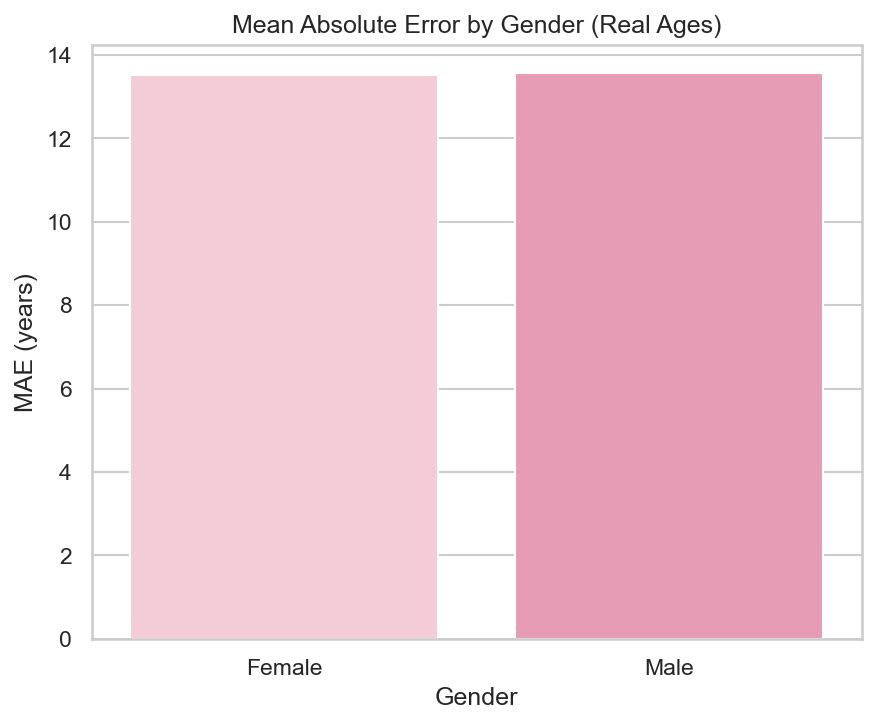

In [ ]:
# --- Race-level statistics ---
race_stats = demo_df.groupby("race_str").agg(
    MAE=("abs_error_real", "mean"),
    RMSE=("abs_error_real", lambda x: math.sqrt(np.mean(x**2))),
    Count=("abs_error_real", "count")
).reset_index()

race_stats_path = os.path.join(OUTPUT_DIR, "race_error_stats.csv")
race_stats.to_csv(race_stats_path, index=False)
print("Saved race error stats to %s", race_stats_path)

race_str, MAE, RMSE, Count

Asian,14.068303,18.104405561421284,588

Black,14.013764,17.766416023781446,673

Indian,13.478057,17.78765742968808,615

Other,11.960738,15.610334426063867,238

White,13.380974,17.17030567499182,1501

In [ ]:
plt.figure(figsize=(8,5))
sns.barplot(data=race_stats, x="race_str", y="MAE", palette="mako")
plt.xlabel("Race")
plt.ylabel("MAE (years)")
plt.title("Mean Absolute Error by Race (Real Ages)")
plt.xticks(rotation=15)
plt.tight_layout()
savefig(os.path.join(OUTPUT_DIR, "mae_by_race.png"))

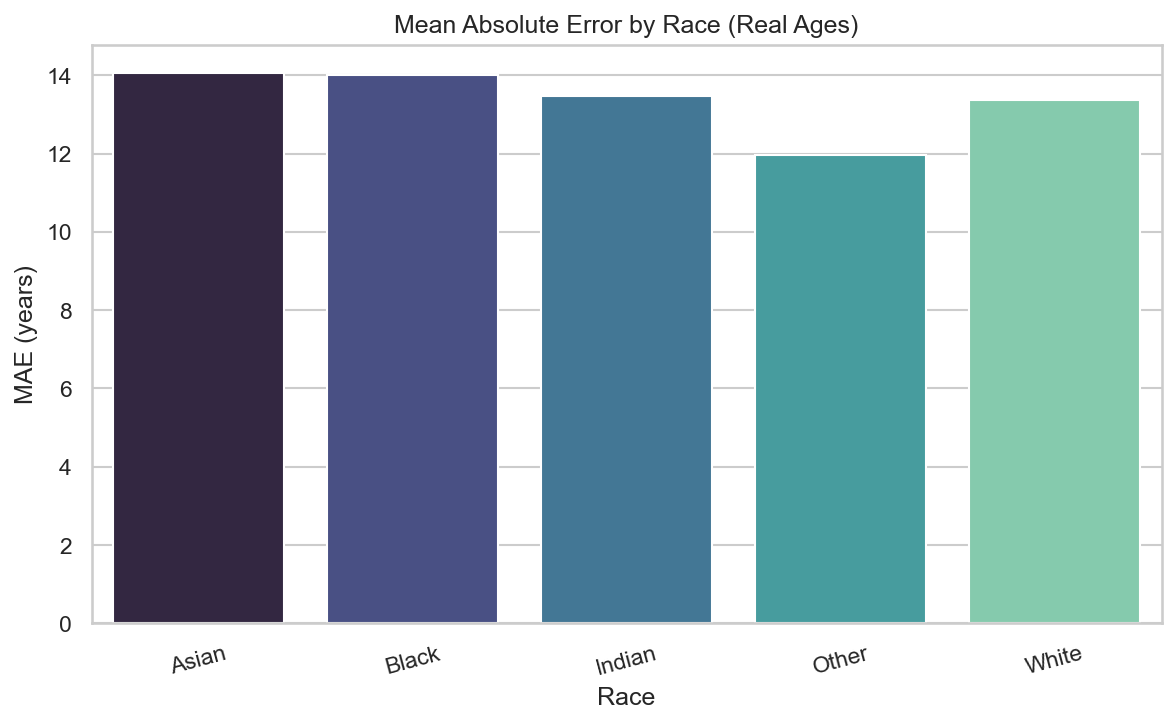